In [0]:
"""Laborator GAN.
   Wasserstein GAN aplicat pe MNIST."""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.examples.tutorials.mnist import input_data
import os
from IPython import display
%matplotlib inline
import time

In [0]:
# Flag pentru train from scratch vs resume
resume = False

In [0]:
# Generare sesiune
session = tf.InteractiveSession()

In [0]:
def generator(z):
  """ Generatorul este o retea convolutionala ce face upsample unui vector z
       de dimensiune 128. 
       Are urmatoarele specificatii: FC(4096) -> Reshape(None, 4, 4, 256) ->
       Upsample(k5x5, s2x2, c128)-> Upsample(k5x5, s2x2, c64) ->
       Upsample(k5x5, s2x2, 1)) -> Sigmoid -> Crop pentru a ajunge in dimensiunea
       imaginii originale mnist 28x28x1
       Unde nu este specificat nu se aplica functie de activare
       
       Folositi layers.fully_connected - pentru Fc, layers_conv2d_transpose pentru
       upsample din pachetul contrib din tensorflow
       
       Intoarceti rezultatul aplicarii retelei convolutionale
       Outputul ar trebui sa fie de aceeasi dimensiune cu imaginea din MNIST
       
  """
  # TODO
  out = tf.contrib.layers.fully_connected(z, 4096)
  out = tf.reshape(out, (-1, 4, 4, 256))
  out = tf.contrib.layers.conv2d_transpose(out, 128, (5, 5), (2, 2), padding='same')
  out = tf.contrib.layers.conv2d_transpose(out, 64, (5, 5), (2, 2), padding='same')
  out = tf.contrib.layers.conv2d_transpose(out, 1, (5, 5), (2, 2), activation_fn=tf.nn.sigmoid)
  out = tf.image.resize_image_with_crop_or_pad(out, 28, 28) # out[2:-2, 2:-2, ]
  return out
  

In [0]:
def discriminator(x, reuse):
  """ Disciminatorul este o retea convolutionala ce primeste ca input un batch
      de imagini.
      Reuse=true face sa refoloseasca toate variabilele din scope-ul discriminatorului
      Reuse=false creaza pentru prima oara variabilele din reteaua discriminatorului
      
      Are urmatoarea structura: Conv2d(k5x5, s2x2, c64, LeakyReLU) -> 
      Conv2d(k5x5, s2x2, c128, LeakyReLU) -> Conv2d(k5x5, s2x2, c256, LeakyReLU)
      -> Flatten -> FC(1)
      Outputul trebuie sa fie un numar (ignorand dimensiunea batchului)
      
  """
  # TODO
  with tf.variable_scope('discriminator', reuse=reuse):
    out = tf.layers.conv2d(x, filters=64, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.leaky_relu, padding='same')
    out = tf.layers.conv2d(out, filters=128, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.leaky_relu, padding='same')
    out = tf.layers.conv2d(out, filters=256, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.leaky_relu, padding='same')
    out = tf.reshape(out, (-1, -1, -1, 1))
    out = tf.contrib.layers.fully_connected(out, 1)
    return out
  

In [0]:
with tf.name_scope('placeholders'):
  """Generare placoholdere pentru 
     x_true - un batch de imagini de dimensiunea  28x28x1
     z - un batch de noise de dimensiunea 128
  """
  x_true = tf.placeholder(tf.float32, [None, 28, 28, 1])
  z = tf.placeholder(tf.float32, [None, 128])

In [0]:
""" 
Pentru a obtine sample-uri din generator trebuie sa facem o inferenta folosind
vectorul de noise z. 
x_generated - un batch de imagini generate cu o inferenta a zgomotului z
"""
x_generated = generator(z)
#TODO

"""
  Pentru a obtine outputul discriminatorului pentru imagini reale si pentru
  sample-uri generate de generatoror trebuie sa facem doua inferente prin discriminator: 
  prima inferenta cu date reale (x_true), iar a doua cu date generate (x_generated)
  d_true - outputul discriminatorului pentru date reale
  d_generated - outputul generatorului pentru date fake
"""
d_true = discriminator(x_true, False)
d_generated = discriminator(x_generated, False)
#TODO

In [0]:
""""
  Teoria WGAN din curs spune ca pentru a putea folosi K-R duality pentru a inversa 
  distanta E-M care da forma loss-ului are nevoie de constrangerea ca functia 
  determinata de discriminator D(x) trebuie sa fie 1-Lipschitz. 

  Aceasta constrangere este inpusa prin alegerea unui punct random interpolat intre
  datele reale si cele fictive si adaugarea unei functii obiectiv regularizante 
  care minimizeaza MSE intre norma 2 a gradientul disctriminatorui in raport cu 
  imaginea interpolata.
"""
with tf.name_scope('regularizer'):
    epsilon = tf.random_uniform([50, 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * x_true + (1 - epsilon) * x_generated
    d_hat = discriminator(x_hat, reuse=True)

    gradients = tf.gradients(d_hat, x_hat)[0]
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
    d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)

In [0]:
with tf.name_scope('loss'):
  """ Crearea functiilor obiectiv pentru generator si pentru discriminator.

      Generatorul incearca sa maximizeze valoarea criticului/discriminatorului pentru 
      datele generate de el (d_generated)
      g_loss - este loss-ul generatorului

      Discriminatorul incearca sa minimizeze valoarea criticului/discriminatorului
      pentru datele generate (d_generated) si incearca sa maximizeze valoarea acestuia
      pentru datele reale (d_true).
      Aditional mai contribuie si loss-ul de regularizare cu o pondere lambda = 10
      d_loss - este lossul discriminatorului
  """
  #TODO

In [0]:
with tf.name_scope('optimizer'):
  """
      Generarea optimizatorului - Adam cu un lr=1e-4, beta1=0, beta2=0.9

      Generarea variabilelor referitor la care vom optimiza: 
      pentru generator le putem accesa folosing colectia variabilelor globale cu scope-ul
      cu care au fost create, idem si pentru discriminator.
      g_train - contine tensorul de optimizare

      Cu aceste variabile putem optimiza fiecare loss in parte raportat la var lui.
      Generator - minimizam loss-ul g_loss raportat la variabilele generatorului
      Discriminator - minimizam loss-ul d_loss raportat la variabilele discriminatorului
      d_train - contine tensorul de optimizare
  """

  #TODO
  #g_vars = tf.get_collection(tf.graphkeys.global_variables, scope='generator')
  #g_train = 

  d_summary = tf.summary.merge([tf.summary.scalar('d_loss', d_loss)])
  g_summary = tf.summary.merge([tf.summary.scalar('g_loss', g_loss)])

In [0]:
# Generare global_step si o operatie ce il incrementeaza
global_step = tf.Variable(0, dtype=tf.int32, name='global_step', trainable=False)
increment_global_step = global_step.assign_add(1)

In [0]:
# Definire saver, generare de foldere pentru modele, summaries
saver = tf.train.Saver()
model_path = os.path.join("models")
summary_path = os.path.join("summaries")
if not resume:
  if os.path.exists(model_path):
    tf.gfile.DeleteRecursively(model_path)
  if os.path.exists(summary_path):
    tf.gfile.DeleteRecursively(summary_path)
  tf.gfile.MakeDirs(model_path)
  tf.gfile.MakeDirs(summary_path)
  
summary_writer = tf.summary.FileWriter(summary_path)

In [0]:
#Initializare sau resume pentru model
if resume:
  session.run(tf.global_variables_initializer())
  ckpt = tf.train.get_checkpoint_state(model_path)
  tf.logging.info("Loading Model from {}".format(ckpt.model_checkpoint_path))
  saver.restore(session, ckpt.model_checkpoint_path)
  session.run(tf.local_variables_initializer())
else:
  session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

In [2]:
#Citirea datasetului 
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


iter=0/20000


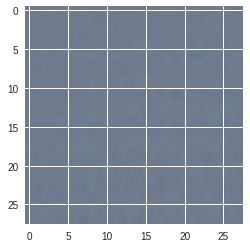

INFO:tensorflow:Saved Model at models/model-0.cptk
iter=100/20000


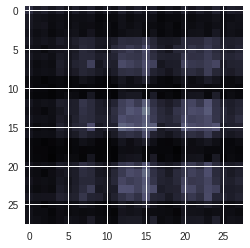

INFO:tensorflow:Saved Model at models/model-100.cptk
iter=200/20000


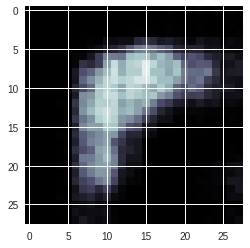

INFO:tensorflow:Saved Model at models/model-200.cptk


In [0]:
i = session.run(global_step)

#Pentru un numar iteratii:
while i <= 20000:
  # extragem un batch de date reale
  # reshape la dimensiunile 28x28x1
  batch = mnist.train.next_batch(50)
  images = batch[0].reshape([-1, 28, 28, 1])
  
  # samplam un batch de zgomot
  z_train = np.random.randn(50, 128)

  # executam gradient descent pe generator feed-uind un batch de zgomot
  #TODO
  #sess.run(g_train, feed_dict={z:z_train})

  # optimizam in loop discriminatorul pentru un numar de iteratii feed-urind
  # un batch de imagini reale si un batch de zgomot pentru cele generate; gradient ascend
  for j in range(5):
    #TODO

  if i % 100 == 0:
    g_summ = session.run(g_summary, feed_dict={z: z_train})
    d_summ = session.run(d_summary, feed_dict={x_true: images, z: z_train})
    summary_writer.add_summary(d_summ, i)
    summary_writer.add_summary(g_summ, i)

  # la fiecare 100 de pasi afisam o imagine generata
  if i % 100 == 0:
    print('iter={}/20000'.format(i))
    # samplam 1 vector de zgomot
    z_validate = np.random.randn(1, 128)
    # rulam tensorul ce contine imaginea generata feeduing zgomotul si afisam
    # matplotlib imaginea
    generated = x_generated.eval(feed_dict={z: z_validate}).squeeze()

    # Image.fromarray(generated.astype(np.uint8)).save(os.path.join(images_path, "image_{}.png".format(i)))
    plt.figure('results')
    plt.imshow(generated, clim=[0, 1], cmap='bone')
    plt.pause(0.001)

    saver.save(session, model_path + '/model-' + str(i) + '.cptk',
               global_step=global_step)
    tf.logging.info("Saved Model at {}".format(model_path + '/model-' + str(i) + '.cptk'))

  session.run(increment_global_step)
  i += 1